In [130]:
from PIL import Image
from ultralytics import YOLO
import numpy as np
import pandas as pd
import cv2
import sys
import os
import time
from copy import deepcopy

In [2]:
model = YOLO("yolov8s.pt") # COCO128 classes https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml
# model = YOLO("yolov8n-seg.pt")

In [131]:
def detection(frames: np.array, should_save: bool = False) -> dict:
    results = model(deepcopy(frames), save=should_save)
    detected = {}

    for frame in range(len(results)):
        # print(frame, results[frame].boxes.numpy(), results[frame].boxes.cls)
        boxes = results[frame].boxes
        detected[frame] = []
        for box in boxes:
            box = box.numpy()
            # print(box, box.cls, box.conf)
            if int(box.cls[0]) == 0 and box.conf[0]> 0.7:
                detected[frame].append({
                    "xyxy": box.xyxy,
                    "xywh": box.xywh,
                    "conf": box.conf[0],
                    "center": box.xywh[0][0:2]
                })
        # print('\n')
    return detected

In [19]:
def distance(point1: np.array, point2: np.array) -> float:
    return np.linalg.norm(point1 - point2)

def is_closer_enough(dist: float, epsilon: float = 30) -> bool:
    return dist <= epsilon

In [141]:
def mean_bbox(frames: dict) -> dict:
    same_bb = []
    mean_bb = []

    if len(frames) > 1:
        for bbox0 in frames[0]: # bbox nel frame 0
            same_bb.append([])
            same_bb[-1].append(bbox0)
            # print(same_bbox)
            # print("0: ", bbox0["center"])

            for bbox1 in frames[1]: # bbox nel frame 1
                # print("\t1: ", bbox1["center"], "DIST: ", distance(bbox0["center"], bbox1["center"]))
                if is_closer_enough(distance(bbox0["center"], bbox1["center"])): # bbox0 <-> bbox1
                    same_bb[-1].append(bbox1)
                    # print("FOUND IT \t1: ", bbox1["center"])

            for bbox2 in frames[2]: # bbox nel frame 2
                # print("\t2: ", bbox2["center"], "DIST: ", distance(same_bbox[-1][-1]["center"], bbox2["center"]))
                if is_closer_enough(distance(same_bb[-1][-1]["center"], bbox2["center"])): # (bbox1 or bbox0) <-> bbox2
                    same_bb[-1].append(bbox2)
                    # print("FOUND IT \t2: ", bbox2["center"])

        # return same_bb
        # print(same_bb)
        # mean_bb = []
        for bboxes in same_bb:
            bbs = {
                "xyxy": np.mean(np.array([frame["xyxy"] for frame in bboxes]), axis=0),
                "xywh": np.mean(np.array([frame["xywh"] for frame in bboxes]), axis=0),
                "conf": np.mean(np.array([frame["conf"] for frame in bboxes])),
                "center": np.mean(np.array([frame["center"] for frame in bboxes]), axis=0),
            }
            # print([frame["xyxy"] for frame in bboxes])
            # mean_bb.append(np.mean(np.array([frame["xyxy"] for frame in bboxes]), axis=0))
            mean_bb.append(bbs)
    else:
        for bbox0 in frames[0]:
            mean_bb.append({
                "xyxy": bbox0["xyxy"],
                "xywh": bbox0["xywh"],
                "conf": bbox0["conf"],
                "center": bbox0["center"],
            })

    return mean_bb

    # for frame_nr, frame in frames.items():
    #     print(frame_nr)
    #     for bbox in frame:
    #         print(bbox)

In [142]:
file_path = 'test.mp4'
delay = 1
window_name = 'frame'

cap = cv2.VideoCapture(file_path)
# cap = cv2.VideoCapture(0)

if not cap.isOpened():
    sys.exit()

count = 3
# frames = []
round = 0
while True:
    reads = [cap.read() for i in range(count)] # [(True, [...]] if frame read else [(False, None)]
    frames = [read[1] for read in reads if read[0]]
    rets = [read[0] for read in reads]

    # os.makedirs("./runs/detect/predict/og/")
    # frames_to_detect = list(frames.copy())

    det = detection(frames, should_save=True)
    mean_bboxes = mean_bbox(det)

    for i in range(len(frames)):
        if rets[i]:
            os.makedirs("./runs/detect/predict/og_f%d/" % i)
            cv2.imwrite("./runs/detect/predict/og_f%d/image.jpg" %i, frames[i])
            for j in range(len(mean_bboxes)):
                cropped = Image.fromarray(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)).crop(mean_bboxes[j]["xyxy"][0].astype(int).tolist())
                # resized = cropped.resize((250, 250))
                cropped.save(f"./runs/detect/predict/og_f{i}/cropped{j}.jpg")
                # cv2.imwrite(f"./runs/detect/predict/og_f{i}/cropped{index}.jpg", resized)

    os.rename("./runs/detect/predict", "./runs/detect/predict%d" % round)

    round += 1

    if rets[2]:
        # cv2.imshow(window_name, frame)
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
    else:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        break

cap.release()
cv2.destroyWindow(window_name)


0: 384x640 3 persons, 1 motorcycle, 2 trucks, 2 chairs, 1 potted plant, 2 dining tables, 3 tvs, 1: 384x640 3 persons, 1 motorcycle, 2 trucks, 1 suitcase, 2 chairs, 1 potted plant, 2 dining tables, 3 tvs, 2: 384x640 3 persons, 1 motorcycle, 2 trucks, 2 chairs, 1 potted plant, 3 dining tables, 3 tvs, 1462.8ms
Speed: 1.9ms pre-process, 487.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

0: 384x640 3 persons, 1 motorcycle, 2 trucks, 1 suitcase, 2 chairs, 1 potted plant, 3 dining tables, 4 tvs, 1: 384x640 3 persons, 1 motorcycle, 1 truck, 2 chairs, 3 dining tables, 4 tvs, 2: 384x640 3 persons, 1 motorcycle, 1 truck, 1 suitcase, 2 chairs, 3 dining tables, 6 tvs, 975.0ms
Speed: 1.4ms pre-process, 325.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

0: 384x640 3 persons, 1 motorcycle, 1 truck, 1 suitcase, 2 chairs, 3 dining tables, 2 tvs, 1: 384x640 3 persons, 1 motorcycle, 1 t

[array([[[ 76,  64,  63],
        [ 79,  67,  66],
        [ 86,  74,  73],
        ...,
        [ 71,  51,  61],
        [ 71,  51,  61],
        [ 71,  51,  61]],

       [[ 79,  67,  66],
        [ 82,  70,  69],
        [ 89,  77,  76],
        ...,
        [ 71,  51,  61],
        [ 71,  51,  61],
        [ 71,  51,  61]],

       [[ 84,  72,  71],
        [ 87,  75,  74],
        [ 90,  78,  77],
        ...,
        [ 71,  51,  61],
        [ 71,  51,  61],
        [ 71,  51,  61]],

       ...,

       [[ 71,  67,  66],
        [ 67,  63,  62],
        [ 54,  50,  49],
        ...,
        [ 90,  89, 102],
        [ 90,  89, 102],
        [ 90,  89, 102]],

       [[ 67,  63,  62],
        [ 70,  66,  65],
        [ 74,  70,  69],
        ...,
        [ 92,  89, 102],
        [ 92,  89, 102],
        [ 92,  89, 102]],

       [[ 65,  61,  60],
        [ 71,  67,  66],
        [ 76,  72,  71],
        ...,
        [ 93,  90, 103],
        [ 93,  90, 103],
        [ 93,  90, 103]

0: 384x640 2 persons, 1 motorcycle, 1 truck, 1 handbag, 2 chairs, 2 dining tables, 3 tvs, 278.2ms
Speed: 0.9ms pre-process, 278.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict



0: 384x640 2 persons, 1 motorcycle, 2 trucks, 2 chairs, 1 potted plant, 1 dining table, 2 tvs, 1: 384x640 3 persons, 1 motorcycle, 2 trucks, 2 chairs, 1 potted plant, 1 dining table, 2 tvs, 2: 384x640 3 persons, 1 motorcycle, 1 truck, 2 chairs, 1 potted plant, 1 dining table, 2 tvs, 1686.2ms
Speed: 11.5ms pre-process, 562.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[{'xyxy': array([[     104.67,      732.33,         455,      1066.7]], dtype=float32), 'xywh': array([[     279.83,       899.5,      350.33,      334.33]], dtype=float32), 'conf': 0.8687261, 'center': array([     279.83,       899.5], dtype=float32)}, {'xyxy': array([[     1606.7,      365.67,        1724,         658]], dtype=float32), 'xywh': array([[     1665.3,      511.83,      117.33,      292.33]], dtype=float32), 'conf': 0.86604017, 'center': array([     1665.3,      511.83], dtype=float32)}]


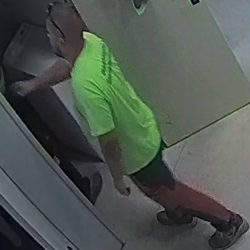

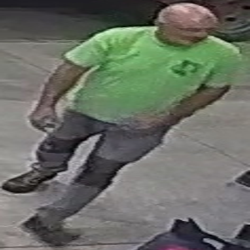

2.2549078464508057


In [114]:
path = "./runs2/detect/predict4/og/image%d.jpg"
frames = [Image.open(path % 0), Image.open(path % 1), Image.open(path % 2)]

start = time.time()
detected = detection(frames)
# detected
mean_bboxes = mean_bbox(detected)
# mean_bboxes

for meanbb in mean_bboxes:
    bbox = meanbb["xyxy"][0].astype(int).tolist()
    # bboxwh = meanbb["xywh"][0].astype(int).tolist()
    cropped = frames[0].crop(bbox)
    resized = cropped.resize((250, 250))
    display(resized)

print(time.time() - start)

In [159]:
file_path = 'test.mp4'
delay = 1
window_name = 'frame'

cap = cv2.VideoCapture(file_path)
# cap = cv2.VideoCapture(0)

if not cap.isOpened():
    sys.exit()

count = 3
frames = []
round = 0
# while round < 20:
while True:
    ret, frame = cap.read()
    frames.append(frame)
    count -= 1
    # print(count, frames)

    if count == 0:
        # print(frames)
        os.makedirs("./runs/detect/predict/og/")
        for index in range(len(frames)):
            cv2.imwrite("./runs/detect/predict/og/image%d.jpg" % index, frames[index])

        bbs = detection(frames)
        os.rename("./runs/detect/predict", "./runs/detect/predict%d" % round)

        count = 3
        frames = []
        round += 1

    if ret:
        # cv2.imshow(window_name, frame)
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
    else:
        os.makedirs("./runs/detect/predict/og/")
        for index in range(len(frames)):
            cv2.imwrite("./runs/detect/predict/og/image%d.jpg" % index, frames[index])
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        break

cap.release()
cv2.destroyWindow(window_name)

Ultralytics YOLOv8.0.25 🚀 Python-3.10.9 torch-1.13.1 CPU
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs

0: 384x640 3 persons, 1 motorcycle, 2 trucks, 2 chairs, 1 potted plant, 2 dining tables, 3 tvs, 1: 384x640 3 persons, 1 motorcycle, 2 trucks, 1 suitcase, 2 chairs, 1 potted plant, 2 dining tables, 3 tvs, 2: 384x640 3 persons, 1 motorcycle, 2 trucks, 2 chairs, 1 potted plant, 3 dining tables, 3 tvs, 1068.4ms
Speed: 3.4ms pre-process, 356.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 motorcycle, 2 trucks, 1 suitcase, 2 chairs, 1 potted plant, 3 dining tables, 4 tvs, 1: 384x640 3 persons, 1 motorcycle, 1 truck, 2 chairs, 3 dining tables, 4 tvs, 2: 384x640 3 persons, 1 motorcycle, 1 truck, 1 suitcase, 2 chairs, 3 dining tables, 6 tvs, 1022.3ms
Speed: 1.9ms pre-process, 340.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 motorcycle, 1 truck, 1 suitcase, 2 chai

error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'
